# LoRA and Domain Adaptation for Text Summarization
# 
# This notebook demonstrates how to use LoRA (Low-Rank Adaptation) for fine-tuning
# language models on summarization tasks.
#
# Assignment objectives:
# 1. Load summarization dataset (XSum)
# 2. Fine-tune a generative model using LoRA
# 3. Experiment with different hyperparameters (batch size, rank)
# 4. Evaluate using ROUGE metrics
# 5. Compare results and show predictions

In [33]:
# Install required packages
!pip install transformers datasets peft accelerate bitsandbytes evaluate rouge_score sentencepiece -q

In [34]:
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel
)
import evaluate
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti
Memory: 17.18 GB


## 1. Dataset Loading and Preparation

We use the **XSum** (Extreme Summarization) dataset from Edinburgh NLP.
- Source: https://huggingface.co/datasets/EdinburghNLP/xsum
- Task: Generate one-sentence summaries of BBC news articles
- We'll use 15,000 random samples for this assignment

In [35]:
# Load XSum dataset
# https://huggingface.co/datasets/EdinburghNLP/xsum
dataset = load_dataset("EdinburghNLP/xsum")

print("Dataset structure:")
print(dataset)
print(f"\nTrain samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

Train samples: 204045
Validation samples: 11332
Test samples: 11334


In [36]:
# Sample 15,000 examples from training set for this assignment
SAMPLE_SIZE = 15000
SEED = 42

# Shuffle and select samples
train_dataset = dataset["train"].shuffle(seed=SEED).select(range(SAMPLE_SIZE))
val_dataset = dataset["validation"].shuffle(seed=SEED).select(range(min(3000, len(dataset["validation"]))))

print(f"Sampled training data: {len(train_dataset)} examples")
print(f"Sampled validation data: {len(val_dataset)} examples")

# Show example
print("\n--- Example from dataset ---")
example = train_dataset[0]
print(f"Document (first 500 chars): {example['document'][:500]}...")
print(f"\nSummary: {example['summary']}")

Sampled training data: 15000 examples
Sampled validation data: 3000 examples

--- Example from dataset ---
Document (first 500 chars): In Wales, councils are responsible for funding and overseeing schools.
But in England, Mr Osborne's plan will mean local authorities will cease to have a role in providing education.
Academies are directly funded by central government and head teachers have more freedom over admissions and to change the way the school works.
It is a significant development in the continued divergence of schools systems on either side of Offa's Dyke.
And although the Welsh Government will get extra cash to match ...

Summary: As Chancellor George Osborne announced all English state schools will become academies, the Welsh Government continues to reject the model here.


## 2. Model Selection

We choose **Qwen2-1.5B** for this task:
- Model: https://huggingface.co/Qwen/Qwen2-1.5B
- Size: 1.5B parameters - good balance between performance and resources
- Architecture: Decoder-only transformer, suitable for text generation
- Supports long context lengths

Alternative models from the assignment:
- bloom-1b1: https://huggingface.co/bigscience/bloom-1b1
- Llama-3.2-1B: https://huggingface.co/meta-llama/Llama-3.2-1B

In [37]:
# Model configuration
MODEL_NAME = "Qwen/Qwen2-1.5B"
MAX_INPUT_LENGTH = 512  # Maximum input tokens
MAX_TARGET_LENGTH = 64  # Maximum summary tokens

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Set padding token if not exists
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"Tokenizer loaded: {MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Pad token: {tokenizer.pad_token}")

Tokenizer loaded: Qwen/Qwen2-1.5B
Vocabulary size: 151643
Pad token: <|endoftext|>


In [38]:
# Load model with optional quantization for memory efficiency
# Use 4-bit quantization if GPU memory is limited

USE_4BIT = True  # Set to False if you have enough GPU memory

if USE_4BIT:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
    )
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
    )

model.config.use_cache = False  # Required for gradient checkpointing

# Print model info
print(f"Model loaded: {MODEL_NAME}")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model loaded: Qwen/Qwen2-1.5B
Total parameters: 888,616,448
Trainable parameters: 233,461,248


## 3. Data Preprocessing

For causal language models, we format the data as:
```
Article: <document text>

Summary: <summary text>
```

The model learns to generate the summary given the article as context.

In [39]:
def format_prompt(document, summary=None):
    """Format input for summarization task."""
    prompt = f"Article: {document}\n\nSummary:"
    if summary:
        return f"{prompt} {summary}"
    return prompt

def preprocess_function(examples):
    """Tokenize and prepare data for training."""
    # Format prompts
    inputs = [format_prompt(doc) for doc in examples["document"]]
    targets = [f" {summary}{tokenizer.eos_token}" for summary in examples["summary"]]
    
    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding=False,
    )
    
    # Tokenize targets
    labels = tokenizer(
        targets,
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding=False,
    )
    
    # Combine input and target for causal LM training
    combined_input_ids = []
    combined_attention_mask = []
    combined_labels = []
    
    for input_ids, label_ids in zip(model_inputs["input_ids"], labels["input_ids"]):
        # Concatenate input and label
        combined = input_ids + label_ids
        
        # Create labels: -100 for input tokens (not used in loss), actual ids for target
        label = [-100] * len(input_ids) + label_ids
        
        combined_input_ids.append(combined)
        combined_attention_mask.append([1] * len(combined))
        combined_labels.append(label)
    
    return {
        "input_ids": combined_input_ids,
        "attention_mask": combined_attention_mask,
        "labels": combined_labels,
    }

# Apply preprocessing
print("Preprocessing training data...")
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing train",
)

print("Preprocessing validation data...")
tokenized_val = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=val_dataset.column_names,
    desc="Tokenizing validation",
)

print(f"\nTokenized train samples: {len(tokenized_train)}")
print(f"Tokenized val samples: {len(tokenized_val)}")
print(f"\nExample tokenized sample length: {len(tokenized_train[0]['input_ids'])}")

Preprocessing training data...
Preprocessing validation data...

Tokenized train samples: 15000
Tokenized val samples: 3000

Example tokenized sample length: 537


## 4. Evaluation Metrics

**Metric Choice: ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**

Motivation for choosing ROUGE:
1. **Standard for summarization**: ROUGE is the most widely used metric for evaluating text summarization
2. **Multi-faceted evaluation**: Provides multiple scores:
   - ROUGE-1: Unigram overlap (captures content coverage)
   - ROUGE-2: Bigram overlap (captures fluency)
   - ROUGE-L: Longest common subsequence (captures sentence structure)
3. **Interpretability**: Scores range from 0 to 1, easy to understand
4. **Comparability**: Results can be compared with published benchmarks

In [40]:
# Load ROUGE metric
rouge = evaluate.load("rouge")

def compute_rouge_metrics(predictions, references):
    """Compute ROUGE metrics for evaluation."""
    results = rouge.compute(
        predictions=predictions, 
        references=references,
        use_stemmer=True
    )
    return {
        "rouge1": results["rouge1"],
        "rouge2": results["rouge2"],
        "rougeL": results["rougeL"],
    }

def generate_summaries(model, dataset, num_samples=100):
    """Generate summaries for evaluation."""
    model.eval()
    predictions = []
    references = []
    
    # Use subset for evaluation
    eval_samples = dataset.select(range(min(num_samples, len(dataset))))
    
    for example in tqdm(eval_samples, desc="Generating summaries"):
        # Format prompt
        prompt = format_prompt(example["document"])
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_INPUT_LENGTH)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Generate
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_TARGET_LENGTH,
                num_beams=4,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
        
        # Decode and extract summary
        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Extract only the summary part (after "Summary:")
        if "Summary:" in generated:
            summary = generated.split("Summary:")[-1].strip()
        else:
            summary = generated[len(prompt):].strip()
        
        predictions.append(summary)
        references.append(example["summary"])
    
    return predictions, references

print("ROUGE metric loaded successfully.")

ROUGE metric loaded successfully.


## 5. LoRA Configuration

**LoRA (Low-Rank Adaptation)** enables efficient fine-tuning by:
- Freezing the original model weights
- Adding small trainable rank decomposition matrices
- Reducing trainable parameters by 100-1000x

Key hyperparameters to experiment with:
- **rank (r)**: Dimension of low-rank matrices (4, 16, 64)
- **alpha**: Scaling factor (typically 2x rank)
- **target_modules**: Which layers to adapt (attention layers)

In [41]:
def create_lora_model(base_model, rank, alpha=None):
    """Create a LoRA-enabled model with specified rank."""
    if alpha is None:
        alpha = rank * 2  # Common practice: alpha = 2 * rank
    
    lora_config = LoraConfig(
        r=rank,
        lora_alpha=alpha,
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.CAUSAL_LM,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    )
    
    # Get PEFT model
    peft_model = get_peft_model(base_model, lora_config)
    
    # Print trainable parameters
    trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in peft_model.parameters())
    
    print(f"LoRA rank: {rank}, alpha: {alpha}")
    print(f"Trainable parameters: {trainable_params:,} ({100 * trainable_params / all_params:.4f}%)")
    
    return peft_model

# Test LoRA configuration
print("Testing LoRA configuration...")
test_lora = create_lora_model(model, rank=8)
test_lora.print_trainable_parameters()

Testing LoRA configuration...
LoRA rank: 8, alpha: 16
Trainable parameters: 9,232,384 (1.0283%)
trainable params: 9,232,384 || all params: 1,552,946,688 || trainable%: 0.5945


## 6. Training with Different Hyperparameters

We experiment with:
- **Batch sizes**: 8, 16 (effective batch with gradient accumulation)
- **LoRA ranks**: 4, 16, 64

Note: Actual batch size depends on GPU memory. We use gradient accumulation to achieve effective batch sizes.

In [42]:
# Data collator for padding
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    max_length=MAX_INPUT_LENGTH + MAX_TARGET_LENGTH,
)

def train_lora_model(base_model, rank, batch_size, num_epochs=1, experiment_name="experiment"):
    """Train a LoRA model with specified hyperparameters."""
    from peft import prepare_model_for_kbit_training
    
    # Reload base model to start fresh
    if USE_4BIT:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True,
        )
        fresh_model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True,
        )
        # Prepare model for kbit training (required for gradient checkpointing with quantized models)
        fresh_model = prepare_model_for_kbit_training(fresh_model)
    else:
        fresh_model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True,
        )
    fresh_model.config.use_cache = False
    
    # Create LoRA model
    peft_model = create_lora_model(fresh_model, rank=rank)
    
    # Calculate gradient accumulation steps
    # Using smaller per_device_batch for memory, accumulate to reach effective batch
    per_device_batch = 2  # Small batch for memory
    gradient_accumulation = batch_size // per_device_batch
    
    # Training arguments
    output_dir = f"./results/{experiment_name}_rank{rank}_batch{batch_size}"
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=per_device_batch,
        per_device_eval_batch_size=per_device_batch,
        gradient_accumulation_steps=gradient_accumulation,
        learning_rate=2e-4,
        warmup_ratio=0.1,
        weight_decay=0.01,
        logging_steps=50,
        eval_strategy="steps",
        eval_steps=200,
        save_strategy="steps",
        save_steps=400,  # Must be multiple of eval_steps=200
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        bf16=True,
        gradient_checkpointing=True,
        optim="paged_adamw_32bit",
        report_to="none",
    )
    
    # Create trainer
    trainer = Trainer(
        model=peft_model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        data_collator=data_collator,
    )
    
    # Train
    print(f"\n{'='*60}")
    print(f"Training: rank={rank}, effective_batch_size={batch_size}")
    print(f"{'='*60}")
    
    trainer.train()
    
    # Save adapter
    adapter_path = f"./adapters/{experiment_name}_rank{rank}_batch{batch_size}"
    peft_model.save_pretrained(adapter_path)
    print(f"Adapter saved to: {adapter_path}")
    
    return peft_model, trainer

print("Training function defined.")

Training function defined.


In [43]:
# Define experiment configurations
# Batch sizes and LoRA ranks to experiment with
BATCH_SIZES = [8, 16]
LORA_RANKS = [4, 16, 64]

# Store results
experiment_results = []

# Note: Running all experiments may take significant time
# You can reduce epochs or use a subset of configurations for faster iteration

print(f"Planned experiments:")
print(f"  Batch sizes: {BATCH_SIZES}")
print(f"  LoRA ranks: {LORA_RANKS}")
print(f"  Total configurations: {len(BATCH_SIZES) * len(LORA_RANKS)}")

Planned experiments:
  Batch sizes: [8, 16]
  LoRA ranks: [4, 16, 64]
  Total configurations: 6


In [44]:
# Run experiments
# This cell runs all experiment configurations
# WARNING: This may take several hours depending on hardware

import os
os.makedirs("./results", exist_ok=True)
os.makedirs("./adapters", exist_ok=True)

NUM_EVAL_SAMPLES = 100  # Samples for ROUGE evaluation

for batch_size in BATCH_SIZES:
    for rank in LORA_RANKS:
        experiment_name = "xsum_summarization"
        
        try:
            # Train model
            trained_model, trainer = train_lora_model(
                base_model=model,
                rank=rank,
                batch_size=batch_size,
                num_epochs=1,
                experiment_name=experiment_name
            )
            
            # Evaluate with ROUGE
            print(f"\nEvaluating model (rank={rank}, batch={batch_size})...")
            predictions, references = generate_summaries(
                trained_model, 
                val_dataset, 
                num_samples=NUM_EVAL_SAMPLES
            )
            
            rouge_scores = compute_rouge_metrics(predictions, references)
            
            # Get final training loss
            train_loss = trainer.state.log_history[-1].get("train_loss", None)
            eval_loss = trainer.state.log_history[-1].get("eval_loss", None)
            
            # Store results
            result = {
                "batch_size": batch_size,
                "lora_rank": rank,
                "train_loss": train_loss,
                "eval_loss": eval_loss,
                "rouge1": rouge_scores["rouge1"],
                "rouge2": rouge_scores["rouge2"],
                "rougeL": rouge_scores["rougeL"],
            }
            experiment_results.append(result)
            
            print(f"\nResults for rank={rank}, batch={batch_size}:")
            print(f"  ROUGE-1: {rouge_scores['rouge1']:.4f}")
            print(f"  ROUGE-2: {rouge_scores['rouge2']:.4f}")
            print(f"  ROUGE-L: {rouge_scores['rougeL']:.4f}")
            
            # Clean up to free memory
            del trained_model
            del trainer
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Error in experiment (rank={rank}, batch={batch_size}): {e}")
            continue

print("\n" + "="*60)
print("All experiments completed!")
print("="*60)

LoRA rank: 4, alpha: 8
Trainable parameters: 4,616,192 (0.5168%)

Training: rank=4, effective_batch_size=8


Step,Training Loss,Validation Loss
200,1.764500,1.734910
400,1.681300,1.684182
600,1.676300,1.656783
800,1.628800,1.639014
1000,1.654900,1.625401
1200,1.617000,1.616287
1400,1.634600,1.608890
1600,1.646900,1.605148
1800,1.583500,1.601503


Adapter saved to: ./adapters/xsum_summarization_rank4_batch8

Evaluating model (rank=4, batch=8)...


Generating summaries: 100%|██████████| 100/100 [06:24<00:00,  3.84s/it]



Results for rank=4, batch=8:
  ROUGE-1: 0.2413
  ROUGE-2: 0.0980
  ROUGE-L: 0.2011
LoRA rank: 16, alpha: 32
Trainable parameters: 18,464,768 (2.0356%)

Training: rank=16, effective_batch_size=8


Step,Training Loss,Validation Loss
200,1.735500,1.719802
400,1.671200,1.670416
600,1.666700,1.646418
800,1.627100,1.624935
1000,1.646400,1.613721
1200,1.601700,1.604303
1400,1.624600,1.593501
1600,1.632400,1.587873
1800,1.565100,1.583308


Adapter saved to: ./adapters/xsum_summarization_rank16_batch8

Evaluating model (rank=16, batch=8)...


Generating summaries: 100%|██████████| 100/100 [07:31<00:00,  4.51s/it]



Results for rank=16, batch=8:
  ROUGE-1: 0.2436
  ROUGE-2: 0.1052
  ROUGE-L: 0.2097
LoRA rank: 64, alpha: 128
Trainable parameters: 73,859,072 (7.6739%)

Training: rank=64, effective_batch_size=8


Step,Training Loss,Validation Loss
200,1.752600,1.749737
400,1.726600,1.712445
600,1.717600,1.690298
800,1.672800,1.667524
1000,1.682500,1.649200
1200,1.632600,1.630967
1400,1.649400,1.611616
1600,1.638500,1.598643
1800,1.568100,1.587629


Adapter saved to: ./adapters/xsum_summarization_rank64_batch8

Evaluating model (rank=64, batch=8)...


Generating summaries: 100%|██████████| 100/100 [06:51<00:00,  4.11s/it]



Results for rank=64, batch=8:
  ROUGE-1: 0.2501
  ROUGE-2: 0.1026
  ROUGE-L: 0.2100
LoRA rank: 4, alpha: 8
Trainable parameters: 4,616,192 (0.5168%)

Training: rank=4, effective_batch_size=16


Step,Training Loss,Validation Loss
200,1.706800,1.701752
400,1.637400,1.649439
600,1.634100,1.626211
800,1.647500,1.615646


Adapter saved to: ./adapters/xsum_summarization_rank4_batch16

Evaluating model (rank=4, batch=16)...


Generating summaries: 100%|██████████| 100/100 [06:59<00:00,  4.19s/it]



Results for rank=4, batch=16:
  ROUGE-1: 0.2372
  ROUGE-2: 0.0930
  ROUGE-L: 0.1936
LoRA rank: 16, alpha: 32
Trainable parameters: 18,464,768 (2.0356%)

Training: rank=16, effective_batch_size=16


Step,Training Loss,Validation Loss
200,1.692900,1.671953
400,1.621100,1.632344
600,1.617000,1.609237
800,1.627200,1.594584


Adapter saved to: ./adapters/xsum_summarization_rank16_batch16

Evaluating model (rank=16, batch=16)...


Generating summaries: 100%|██████████| 100/100 [07:49<00:00,  4.69s/it]



Results for rank=16, batch=16:
  ROUGE-1: 0.2445
  ROUGE-2: 0.0990
  ROUGE-L: 0.2016
LoRA rank: 64, alpha: 128
Trainable parameters: 73,859,072 (7.6739%)

Training: rank=64, effective_batch_size=16


Step,Training Loss,Validation Loss
200,1.707500,1.688663
400,1.630700,1.637226
600,1.618100,1.608074
800,1.622500,1.586847


Adapter saved to: ./adapters/xsum_summarization_rank64_batch16

Evaluating model (rank=64, batch=16)...


Generating summaries: 100%|██████████| 100/100 [06:35<00:00,  3.96s/it]



Results for rank=64, batch=16:
  ROUGE-1: 0.2530
  ROUGE-2: 0.1103
  ROUGE-L: 0.2127

All experiments completed!


## 7. Results Analysis

Display metrics table for all hyperparameter configurations.

In [45]:
# Create results DataFrame
results_df = pd.DataFrame(experiment_results)

# Display results table
print("=" * 80)
print("EXPERIMENT RESULTS: LoRA Fine-tuning for Summarization")
print("=" * 80)

if results_df.empty:
    print("\nNo experiment results available. Please run the training cell first.")
    print("Make sure experiments complete successfully before analyzing results.")
else:
    # Format table for display
    display_df = results_df.copy()
    display_df = display_df.round(4)
    print(display_df.to_string(index=False))

    # Find best configuration
    best_idx = results_df["rougeL"].idxmax()
    best_config = results_df.loc[best_idx]

    print("\n" + "=" * 80)
    print("BEST CONFIGURATION:")
    print("=" * 80)
    print(f"  Batch Size: {best_config['batch_size']}")
    print(f"  LoRA Rank: {best_config['lora_rank']}")
    print(f"  ROUGE-1: {best_config['rouge1']:.4f}")
    print(f"  ROUGE-2: {best_config['rouge2']:.4f}")
    print(f"  ROUGE-L: {best_config['rougeL']:.4f}")

EXPERIMENT RESULTS: LoRA Fine-tuning for Summarization
 batch_size  lora_rank  train_loss eval_loss  rouge1  rouge2  rougeL
          8          4      1.6765      None  0.2413  0.0980  0.2011
          8         16      1.6607      None  0.2436  0.1052  0.2097
          8         64      1.6838      None  0.2501  0.1026  0.2100
         16          4      1.6922      None  0.2372  0.0930  0.1936
         16         16      1.6690      None  0.2445  0.0990  0.2016
         16         64      1.6664      None  0.2530  0.1103  0.2127

BEST CONFIGURATION:
  Batch Size: 16
  LoRA Rank: 64
  ROUGE-1: 0.2530
  ROUGE-2: 0.1103
  ROUGE-L: 0.2127


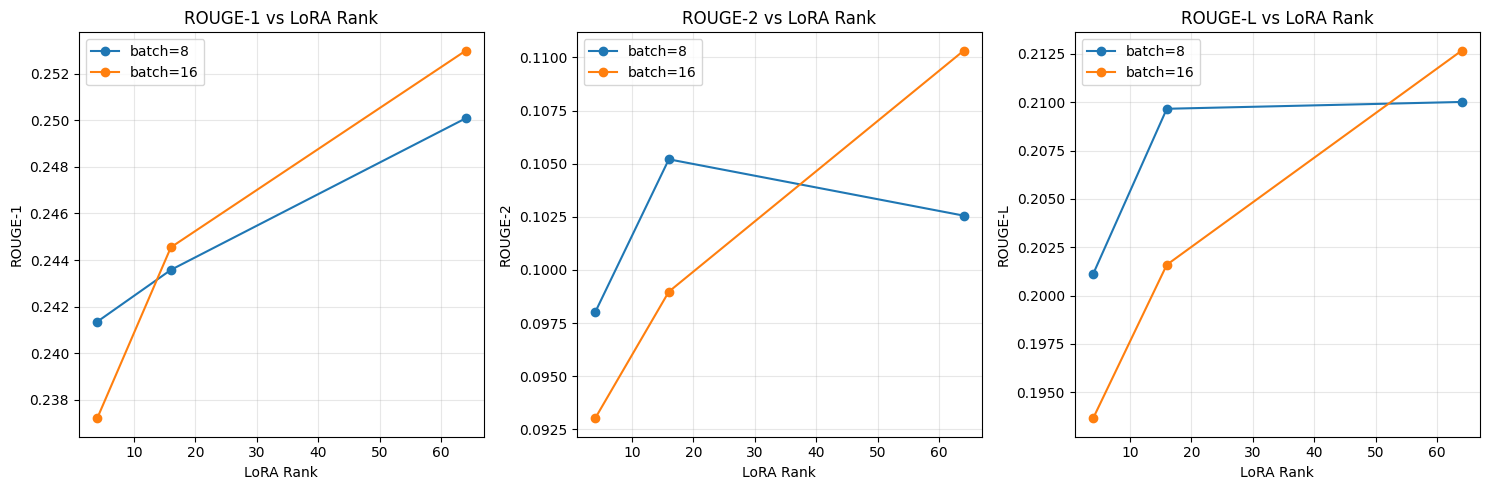

Results visualization saved to: ./results/lora_experiment_results.png


In [46]:
import matplotlib.pyplot as plt

if results_df.empty:
    print("No results to visualize. Please run training experiments first.")
else:
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    metrics = ["rouge1", "rouge2", "rougeL"]
    titles = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]

    for ax, metric, title in zip(axes, metrics, titles):
        for batch_size in BATCH_SIZES:
            subset = results_df[results_df["batch_size"] == batch_size]
            ax.plot(subset["lora_rank"], subset[metric], marker="o", label=f"batch={batch_size}")
        
        ax.set_xlabel("LoRA Rank")
        ax.set_ylabel(title)
        ax.set_title(f"{title} vs LoRA Rank")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("./results/lora_experiment_results.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("Results visualization saved to: ./results/lora_experiment_results.png")

## 8. Best Model Predictions

Demonstrate predictions from the best performing model.

In [47]:
if results_df.empty:
    print("No experiment results available. Cannot load best model.")
    print("Please run training experiments first.")
    best_model = None
else:
    # Load the best model
    best_rank = int(best_config["lora_rank"])
    best_batch = int(best_config["batch_size"])
    best_adapter_path = f"./adapters/xsum_summarization_rank{best_rank}_batch{best_batch}"

    print(f"Loading best adapter from: {best_adapter_path}")

    # Load base model
    if USE_4BIT:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True,
        )
        best_base_model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True,
        )
    else:
        best_base_model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True,
        )

    # Load LoRA adapter
    best_model = PeftModel.from_pretrained(best_base_model, best_adapter_path)
    best_model.eval()

    print("Best model loaded successfully!")

Loading best adapter from: ./adapters/xsum_summarization_rank64_batch16
Best model loaded successfully!


In [48]:
def generate_single_summary(model, document):
    """Generate a summary for a single document."""
    prompt = format_prompt(document)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_INPUT_LENGTH)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_TARGET_LENGTH,
            num_beams=4,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
        )
    
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract summary part
    if "Summary:" in generated:
        summary = generated.split("Summary:")[-1].strip()
    else:
        summary = generated[len(prompt):].strip()
    
    return summary

if best_model is None:
    print("No best model available. Please run training experiments first.")
else:
    # Show predictions for several validation examples
    NUM_DEMO_SAMPLES = 5

    print("=" * 80)
    print("SAMPLE PREDICTIONS FROM BEST MODEL")
    print("=" * 80)

    for i in range(NUM_DEMO_SAMPLES):
        example = val_dataset[i]
        
        # Generate prediction
        predicted_summary = generate_single_summary(best_model, example["document"])
        
        # Calculate ROUGE for this example
        example_rouge = compute_rouge_metrics([predicted_summary], [example["summary"]])
        
        print(f"\n{'='*80}")
        print(f"EXAMPLE {i+1}")
        print(f"{'='*80}")
        print(f"\nDOCUMENT (first 500 chars):")
        print(f"{example['document'][:500]}...")
        print(f"\nREFERENCE SUMMARY:")
        print(f"{example['summary']}")
        print(f"\nGENERATED SUMMARY:")
        print(f"{predicted_summary}")
        print(f"\nROUGE SCORES for this example:")
        print(f"  ROUGE-1: {example_rouge['rouge1']:.4f}")
        print(f"  ROUGE-2: {example_rouge['rouge2']:.4f}")
        print(f"  ROUGE-L: {example_rouge['rougeL']:.4f}")

SAMPLE PREDICTIONS FROM BEST MODEL

EXAMPLE 1

DOCUMENT (first 500 chars):
Patrick Joseph Connors, 59, his son Patrick Dean Connors, 39, and nephew William Connors, 36, denied requiring a person to perform forced or compulsory labour between 2010 and 2013.
They were convicted by a jury at Cardiff Crown Court on Tuesday.
Connors senior was jailed for 14 years, Patrick Dean for six-and-a-half years and William for four years.
Patrick Joseph Connors' son-in-law Lee Carbis, 34, who was cleared of forced labour, but found guilty of kidnap, was jailed for two-and-a-half year...

REFERENCE SUMMARY:
Three family members have been jailed for forcing a man to do heavy labour for tiny amounts in Cardiff.

GENERATED SUMMARY:


ROUGE SCORES for this example:
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000

EXAMPLE 2

DOCUMENT (first 500 chars):
The visitors were closing in on three points thanks to Christian Nade's first-half penalty and a fine finish from Robert Thomson.
But Martin Boyle's l

## 9. Analysis and Potential Improvements

### Observations:
1. **LoRA Rank Impact**: Higher ranks typically capture more complex patterns but may overfit on small datasets
2. **Batch Size Effect**: Larger batch sizes provide more stable gradients but may converge to different optima
3. **Training Efficiency**: LoRA reduces trainable parameters by ~99%, enabling efficient fine-tuning

### Potential Improvements if Results are Unsatisfactory:

1. **Increase Training Data**: Use more than 15K samples from the full dataset
2. **More Training Epochs**: Train for 2-3 epochs instead of 1
3. **Learning Rate Tuning**: Experiment with learning rates (1e-4 to 5e-4)
4. **Different Target Modules**: Include more layers in LoRA adaptation
5. **Prompt Engineering**: Experiment with different prompt formats
6. **Beam Search Parameters**: Adjust num_beams and length penalties
7. **Use Larger Base Model**: If resources allow, try 3B+ parameter models
8. **Data Augmentation**: Apply text augmentation techniques
9. **Ensemble Methods**: Combine predictions from multiple LoRA configurations

## 10. Summary and Links

### Resources Used:
- **Dataset**: [EdinburghNLP/xsum](https://huggingface.co/datasets/EdinburghNLP/xsum)
- **Base Model**: [Qwen/Qwen2-1.5B](https://huggingface.co/Qwen/Qwen2-1.5B)
- **PEFT Library**: [huggingface/peft](https://github.com/huggingface/peft)
- **LoRA Paper**: [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)

### Adapters Saved:
Trained LoRA adapters are saved in the `./adapters/` directory and can be:
1. Loaded with `PeftModel.from_pretrained()`
2. Uploaded to Hugging Face Hub
3. Shared for reproducibility

### Key Takeaways:
1. LoRA enables efficient fine-tuning with <1% of original parameters
2. Different rank/batch size combinations yield different performance trade-offs
3. ROUGE metrics provide multi-faceted evaluation of summarization quality
4. Causal LM models can be effectively adapted for summarization with proper prompt formatting

In [49]:
# Save results to CSV for future reference
if not results_df.empty:
    results_df.to_csv("./results/lora_experiment_results.csv", index=False)
    print("Results saved to: ./results/lora_experiment_results.csv")

# Display final summary
print("\n" + "=" * 80)
print("EXPERIMENT COMPLETE")
print("=" * 80)
print(f"\nModel: {MODEL_NAME}")
print(f"Dataset: XSum ({SAMPLE_SIZE} training samples)")
print(f"Configurations tested: {len(experiment_results)}")

if not results_df.empty:
    print(f"\nBest Configuration:")
    print(f"  LoRA Rank: {best_config['lora_rank']}")
    print(f"  Batch Size: {best_config['batch_size']}")
    print(f"  Best ROUGE-L: {best_config['rougeL']:.4f}")
    print(f"\nAdapters saved to: ./adapters/")
    print(f"Results saved to: ./results/")
else:
    print("\nNo successful experiments completed.")
    print("Please check the training logs for errors.")

Results saved to: ./results/lora_experiment_results.csv

EXPERIMENT COMPLETE

Model: Qwen/Qwen2-1.5B
Dataset: XSum (15000 training samples)
Configurations tested: 6

Best Configuration:
  LoRA Rank: 64
  Batch Size: 16
  Best ROUGE-L: 0.2127

Adapters saved to: ./adapters/
Results saved to: ./results/
